## Notebook for assigning electrolyte score

### Database: PubChem (from ~100 million)

**Created on 14th November, 2022; remodified on 12th February, 2024**

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, PandasTools, Fragments, rdMolDescriptors, Descriptors
import numpy as np
from sklearn import preprocessing

In [2]:
%%bash
pwd
ls -ltr

/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/liquid-electrolyte-ML/Science-rev-1/escore-calcs/pubchem-100m
total 2224
-rw-------@ 1 riteshk  staff  77447839 Feb 11 13:33 preds_oxstab_pubchem_screen_100m_021124.csv
-rw-------@ 1 riteshk  staff  97433577 Feb 11 13:34 preds_cond_pubchem_screen_100m_021124.csv
-rw-------@ 1 riteshk  staff  98679652 Feb 12 13:31 preds_ce_pubchem_screen_100m_021224.csv
-rw-------@ 1 riteshk  staff  98730965 Feb 12 14:14 preds_ce_pubchem_screen_100m_021224_2M.csv
-rw-------@ 1 riteshk  staff    391646 Feb 12 14:16 deploy_ce_pubchem100m.ipynb
-rw-------@ 1 riteshk  staff   1135099 Feb 12 15:25 assign-electrolyte-score_3.ipynb


In [6]:
rem_ind = np.genfromtxt('index_pubchem_ce_removed_021224.txt', dtype=int)
rem_ind

array([763362, 147011, 551739, 602941, 530590])

In [11]:
# df_pub = pd.read_csv('preds_cond_pubchem_screen_100m_021124.csv')
df_pub = pd.read_csv('preds_cond_pubchem_screen_100m_021224.csv')
df_pub

,solv_comb_sm,salt_sm,conductivity_log,conductivity_log_ensemble_uncal_var
0,CC(C)OC1(C=O)CCSCC1,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],0.317242,0.007473
1,COC(C)(CC=O)C1CCN(C)CC1,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],0.353623,0.005920
2,CN1CCCC(C=O)(OC(C)(C)C)CC1,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],0.267182,0.003646
3,CC(=O)C1(S(=O)(=O)N2CCCC2)CCC1,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.839024,0.282831
4,COC(=O)CC(=O)C1(C)CCS(=O)(=O)CC1,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.147275,0.108218
...,...,...,...,...
982567,CN(C)CC(=O)N1CC2COCC2(COCC2CCOCC2)C1,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],0.085919,0.006982
982568,CN1CCC2(C(=O)N3CCOCC3)CCN(S(C)(=O)=O)CCC12,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.444187,0.041032
982569,CC(=O)N1CCC2CN(C)S(=O)(=O)C2CC1,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.176313,0.028160
982570,CCS(=O)(=O)N1CCC2OC(COCC3CCOCC3)CCC21,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.092601,0.033724


In [7]:
# df_pub.drop(index=rem_ind, inplace=True)
# df_pub.reset_index(drop=True, inplace=True)
# df_pub

,solv_comb_sm,salt_sm,conductivity_log,conductivity_log_ensemble_uncal_var
0,CC(C)OC1(C=O)CCSCC1,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],0.317242,0.007473
1,COC(C)(CC=O)C1CCN(C)CC1,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],0.353623,0.005920
2,CN1CCCC(C=O)(OC(C)(C)C)CC1,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],0.267182,0.003646
3,CC(=O)C1(S(=O)(=O)N2CCCC2)CCC1,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.839024,0.282831
4,COC(=O)CC(=O)C1(C)CCS(=O)(=O)CC1,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.147275,0.108218
...,...,...,...,...
982567,CN(C)CC(=O)N1CC2COCC2(COCC2CCOCC2)C1,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],0.085919,0.006982
982568,CN1CCC2(C(=O)N3CCOCC3)CCN(S(C)(=O)=O)CCC12,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.444187,0.041032
982569,CC(=O)N1CCC2CN(C)S(=O)(=O)C2CC1,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.176313,0.028160
982570,CCS(=O)(=O)N1CCC2OC(COCC3CCOCC3)CCC21,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.092601,0.033724


In [10]:
# df_pub.to_csv('preds_cond_pubchem_screen_100m_021224.csv', index=False)

In [5]:
df_pub_ce = pd.read_csv('preds_ce_pubchem_screen_100m_021224_2M.csv')
df_pub_ce

,solv_comb_sm,salt_sm,log(1-CE),log(1-CE)_uncal_var
0,CC(C)OC1(C=O)CCSCC1,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.639895,0.089666
1,COC(C)(CC=O)C1CCN(C)CC1,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.515042,0.100956
2,CN1CCCC(C=O)(OC(C)(C)C)CC1,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.600324,0.086095
3,CC(=O)C1(S(=O)(=O)N2CCCC2)CCC1,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.487012,0.110545
4,COC(=O)CC(=O)C1(C)CCS(=O)(=O)CC1,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.401482,0.104729
...,...,...,...,...
982567,CN(C)CC(=O)N1CC2COCC2(COCC2CCOCC2)C1,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.173198,0.049696
982568,CN1CCC2(C(=O)N3CCOCC3)CCN(S(C)(=O)=O)CCC12,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.151105,0.062979
982569,CC(=O)N1CCC2CN(C)S(=O)(=O)C2CC1,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.376761,0.088472
982570,CCS(=O)(=O)N1CCC2OC(COCC3CCOCC3)CCC21,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.196154,0.090661


In [28]:
df_pub_ce.sort_values(by='log(1-CE)', ascending=True)

,solv_comb_sm,salt_sm,log(1-CE),log(1-CE)_uncal_var
419312,B12B3B4B1[Si]234,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-9.247004,1.146585
323941,S=S=PP(=S)=S,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-6.557823,3.038555
15900,N#CP(=S)=S,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-6.347858,2.735268
602805,O=P(=O)P(=O)=O,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-5.291956,2.772355
146175,[B]1B2OB3B4B1B3B24,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-5.125084,1.133100
...,...,...,...,...
694285,[Si]12[Si]3[Si]1[Si]1[Si]2[Si]31,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],6.572280,1.345320
325261,[Si]12[Si]3[Si]4[Si]1[Si]1[Si]2[Si]3[Si]41,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],6.677680,1.341019
447940,[Si]12[Si]3[Si]4[Si]1[Si]1[Si]2[Si]2[Si]3[Si]4...,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],6.783081,1.337087
540497,[Si]12[Si]3[Si]4[Si]1[Si]1[Si]4[Si]4[Si]5[Si]3...,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],6.888482,1.333528


In [29]:
df_pub_ce.loc[df_pub_ce['log(1-CE)'] > 0.0, 'log(1-CE)'] = 0.0 ## replacing all predicted log(1-CE) > 0.0 with 0.0 as it would lead to unphysical negative CE values
df_pub_ce.sort_values(by='log(1-CE)', ascending=True)

,solv_comb_sm,salt_sm,log(1-CE),log(1-CE)_uncal_var
419312,B12B3B4B1[Si]234,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-9.247004,1.146585
323941,S=S=PP(=S)=S,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-6.557823,3.038555
15900,N#CP(=S)=S,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-6.347858,2.735268
602805,O=P(=O)P(=O)=O,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-5.291956,2.772355
146175,[B]1B2OB3B4B1B3B24,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-5.125084,1.133100
...,...,...,...,...
226315,C[Si][Si]([Si])[Si]([Si]C)([Si]C)[Si][Si][Si][Si],O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],0.000000,0.484804
793950,O1[Si]2O[Si]3O[Si]4O[Si]1O[Si]1O[Si](O2)O[Si](...,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],0.000000,0.384134
542678,[SiH]12[SiH]3[SiH]1[SiH]1[SiH]2[SiH]31,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],0.000000,0.704208
970751,B12[Si]3[Si]4[Si]1[Si]1[Si]2[Si]3[Si]41,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],0.000000,1.320537


In [12]:
# df_pub.iloc[763362]

solv_comb_sm                           [B]C1C2OC(C)(C)OC2C(CO[Si](C)(C)C(C)(C)C)C12CC2
salt_sm                                                 O=S(=O)(F)[N-]S(=O)(=O)F.[Li+]
conductivity_log                                                             -0.421977
conductivity_log_ensemble_uncal_var                                           0.058221
Name: 763362, dtype: object

In [13]:
# df_pub_ce.iloc[763362]

solv_comb_sm           [B]C1C2OC(C)(C)OC2C(CO[Si](C)(C)C(C)(C)C)C12CC2
salt_sm                                 O=S(=O)(F)[N-]S(=O)(=O)F.[Li+]
log(1-CE)                                                    -1.444303
log(1-CE)_uncal_var                                           0.057172
Name: 763362, dtype: object

In [17]:
df_pub_os = pd.read_csv('preds_oxstab_pubchem_screen_100m_021224.csv')
# df_pub_os = pd.read_csv('preds_oxstab_pubchem_screen_100m_021124.csv')
# df_pub_os.drop(index=rem_ind, inplace=True)
# df_pub_os.reset_index(drop=True, inplace=True)
df_pub_os

,solv_comb_sm,salt_sm,IE
0,CC(C)OC1(C=O)CCSCC1,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],4.750232
1,COC(C)(CC=O)C1CCN(C)CC1,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],4.294417
2,CN1CCCC(C=O)(OC(C)(C)C)CC1,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],4.184543
3,CC(=O)C1(S(=O)(=O)N2CCCC2)CCC1,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],5.075937
4,COC(=O)CC(=O)C1(C)CCS(=O)(=O)CC1,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],5.900624
...,...,...,...
982567,CN(C)CC(=O)N1CC2COCC2(COCC2CCOCC2)C1,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],4.331752
982568,CN1CCC2(C(=O)N3CCOCC3)CCN(S(C)(=O)=O)CCC12,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],4.179219
982569,CC(=O)N1CCC2CN(C)S(=O)(=O)C2CC1,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],4.714354
982570,CCS(=O)(=O)N1CCC2OC(COCC3CCOCC3)CCC21,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],4.685297


In [18]:
df_pub_os.iloc[763362]

solv_comb_sm    [B]C1C2OC(C)(C)OC2C(CO[Si](C)(C)C(C)(C)C)C12CC2
salt_sm                          O=S(=O)(F)[N-]S(=O)(=O)F.[Li+]
IE                                                       4.1936
Name: 763362, dtype: object

In [16]:
# df_pub_os.to_csv('preds_oxstab_pubchem_screen_100m_021224.csv', index=False)

In [19]:
## reading original datasets
df_cond = pd.read_csv('../all_multi_comp_cond_comm.csv')
df_cond['conductivity'] = np.power(10, df_cond['conductivity_log'])
cond = df_cond['conductivity']
df_os = pd.read_csv('../all_oxstab.csv')
oxstab = df_os['IE']
df_ce = pd.read_csv('../all_multi_comp_ce.csv')
ce = df_ce['coulombic_efficiency']
df_ce

,solvent_1_smiles,solvent_2_smiles,solvent_3_smiles,salt_1_smiles,salt_2_smiles,additive_smiles,protocol,current_density,coulombic_efficiency
0,CC1COC(=O)O1,NaN,NaN,[Li+].[O-][Cl+3]([O-])([O-])[O-],NaN,NaN,0,2.0,0.80000
1,CC1COC(=O)O1,NaN,NaN,[Li+].[O-][Cl+3]([O-])([O-])[O-],NaN,O=S=O,1,5.0,0.83600
2,C1CCOC1,NaN,NaN,F[As-](F)(F)(F)(F)F.[Li+],NaN,NaN,1,5.0,0.89400
3,CC1CCCO1,NaN,NaN,F[As-](F)(F)(F)(F)F.[Li+],NaN,NaN,1,0.9,0.97400
4,CC1CCCO1,NaN,NaN,F[As-](F)(F)(F)(F)F.[Li+],NaN,NaN,1,0.9,0.97400
...,...,...,...,...,...,...,...,...,...
137,CO[Si](C)(C)OC,NaN,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,2,0.5,0.99759
138,O=S1(=O)CCCC1,NaN,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,2,0.5,0.98200
139,O=S1(=O)CCCC1,FC(F)C(F)(F)COC(F)(F)C(F)F,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,2,0.5,0.98800
140,COC1OCC(C(F)(F)F)O1,NaN,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,2,1.0,0.98700


In [20]:
## Extremum values of all original datasets
print(max(cond), min(cond))
print(max(oxstab), min(oxstab))
print(max(ce), min(ce))

66.79000001752941 1.790000001979125e-07
11.03454344 0.027343104
0.9994000000001512 0.0899999995711704


In [30]:
df_pub['conductivity'] = np.power(10, df_pub['conductivity_log'])
df_pub['coulombic_efficiency'] = 1 - np.power(10, df_pub_ce['log(1-CE)'])
df_pub['oxstab'] = df_pub_os['IE']
df_pub

,solv_comb_sm,salt_sm,conductivity_log,conductivity_log_ensemble_uncal_var,conductivity,coulombic_efficiency,oxstab
0,CC(C)OC1(C=O)CCSCC1,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],0.317242,0.007473,2.076072,0.977086,4.750232
1,COC(C)(CC=O)C1CCN(C)CC1,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],0.353623,0.005920,2.257475,0.969454,4.294417
2,CN1CCCC(C=O)(OC(C)(C)C)CC1,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],0.267182,0.003646,1.850043,0.974900,4.184543
3,CC(=O)C1(S(=O)(=O)N2CCCC2)CCC1,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.839024,0.282831,0.014487,0.967417,5.075937
4,COC(=O)CC(=O)C1(C)CCS(=O)(=O)CC1,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.147275,0.108218,0.071240,0.960325,5.900624
...,...,...,...,...,...,...,...
982567,CN(C)CC(=O)N1CC2COCC2(COCC2CCOCC2)C1,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],0.085919,0.006982,1.218762,0.932888,4.331752
982568,CN1CCC2(C(=O)N3CCOCC3)CCN(S(C)(=O)=O)CCC12,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.444187,0.041032,0.359594,0.929385,4.179219
982569,CC(=O)N1CCC2CN(C)S(=O)(=O)C2CC1,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.176313,0.028160,0.666327,0.958001,4.714354
982570,CCS(=O)(=O)N1CCC2OC(COCC3CCOCC3)CCC21,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.092601,0.033724,0.807978,0.936343,4.685297


In [31]:
pub_cond = df_pub['conductivity']
pub_os = df_pub['oxstab']
pub_ce = df_pub['coulombic_efficiency']

In [33]:
## Extreme values of all predicted properties for emolecules dataset
print(max(pub_cond), min(pub_cond))
print(max(pub_os), min(pub_os))
print(max(pub_ce), min(pub_ce))

20.65890928550253 2.733464672277936e-05
9.998654284560304 0.511165500761506
0.9999999994337653 0.0


**Step 1: Normalization**

In [34]:
## Define a scaler for conductivity
cond_div = np.linspace(max(cond), min(cond),1000000) ## dividing the range into 1 million points
cond_div = cond_div.reshape(-1, 1)
scaler_cond = preprocessing.MinMaxScaler() ## Using MinMax Scaler
scaler_cond.fit(cond_div)
cond_sc = scaler_cond.transform(cond_div)
cond_sc

array([[1.000000e+00],
       [9.999990e-01],
       [9.999980e-01],
       ...,
       [2.000002e-06],
       [1.000001e-06],
       [0.000000e+00]])

In [35]:
## Standardize the original conductivity values
pub_cond = np.array(pub_cond).reshape(-1,1)
pub_cond_sc = scaler_cond.transform(pub_cond)
print(pub_cond_sc)
print(max(pub_cond_sc), min(pub_cond_sc))

[[0.03108357]
 [0.03379959]
 [0.0276994 ]
 ...
 [0.00997644]
 [0.01209729]
 [0.04422206]]
[0.30931141] [4.06582524e-07]


In [36]:
## Define a scaler for oxidative stability
os_div = np.linspace(max(oxstab), min(oxstab),1000000).reshape(-1, 1)
scaler_os = preprocessing.MinMaxScaler()
scaler_os.fit(os_div)
scaler_os.transform(os_div)

array([[1.000000e+00],
       [9.999990e-01],
       [9.999980e-01],
       ...,
       [2.000002e-06],
       [1.000001e-06],
       [0.000000e+00]])

In [37]:
## Standardize the original oxidative stability values
pub_os = np.array(pub_os).reshape(-1,1)
pub_os_sc = scaler_os.transform(pub_os)
print(pub_os_sc)
print(max(pub_os_sc), min(pub_os_sc))

[[0.42907271]
 [0.38766204]
 [0.37768007]
 ...
 [0.42581319]
 [0.4231734 ]
 [0.36766236]]
[0.90588986] [0.04395508]


In [38]:
## Define a scaler for coulombic efficiency
ce_div = np.linspace(max(ce), min(ce),1000000).reshape(-1, 1)
scaler_ce = preprocessing.MinMaxScaler()
scaler_ce.fit(ce_div)
scaler_ce.transform(ce_div)

array([[1.000000e+00],
       [9.999990e-01],
       [9.999980e-01],
       ...,
       [2.000002e-06],
       [1.000001e-06],
       [0.000000e+00]])

In [39]:
## Standardize the original coulombic efficiency values
pub_ce = np.array(pub_ce).reshape(-1,1)
pub_ce_sc = scaler_ce.transform(pub_ce)
print(pub_ce_sc)
print(max(pub_ce_sc), min(pub_ce_sc))

[[0.97546273]
 [0.96707033]
 [0.97305901]
 ...
 [0.95447661]
 [0.93066092]
 [0.94333566]]
[1.00065978] [-0.09896635]


In [40]:
## Combine the standardized values into a dataframe
target_df = pd.DataFrame()
target_df['solv_comb_sm'] = df_pub['solv_comb_sm']
target_df['conductivity'] = df_pub['conductivity']
target_df['oxstab'] = df_pub['oxstab']
target_df['coulombic_efficiency'] = df_pub['coulombic_efficiency']
# target_df['similarity'] = emol_max_sim
target_df

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency
0,CC(C)OC1(C=O)CCSCC1,2.076072,4.750232,0.977086
1,COC(C)(CC=O)C1CCN(C)CC1,2.257475,4.294417,0.969454
2,CN1CCCC(C=O)(OC(C)(C)C)CC1,1.850043,4.184543,0.974900
3,CC(=O)C1(S(=O)(=O)N2CCCC2)CCC1,0.014487,5.075937,0.967417
4,COC(=O)CC(=O)C1(C)CCS(=O)(=O)CC1,0.071240,5.900624,0.960325
...,...,...,...,...
982567,CN(C)CC(=O)N1CC2COCC2(COCC2CCOCC2)C1,1.218762,4.331752,0.932888
982568,CN1CCC2(C(=O)N3CCOCC3)CCN(S(C)(=O)=O)CCC12,0.359594,4.179219,0.929385
982569,CC(=O)N1CCC2CN(C)S(=O)(=O)C2CC1,0.666327,4.714354,0.958001
982570,CCS(=O)(=O)N1CCC2OC(COCC3CCOCC3)CCC21,0.807978,4.685297,0.936343


In [41]:
target_df['cond_std'] = pub_cond_sc
target_df['oxstab_std'] = pub_os_sc
target_df['CE_std'] = pub_ce_sc

In [30]:
# target_df[['conductivity','cond_std']]

,conductivity,cond_std
0,0.704895,0.010554
1,8.206602,0.122872
2,3.362226,0.050340
3,7.094224,0.106217
4,2.286502,0.034234
...,...,...
899361,0.005344,0.000080
899362,0.012404,0.000186
899363,0.008612,0.000129
899364,0.181364,0.002715


1. Equal weights for $\sigma$, CE, & IE

In [42]:
cond_score_1 = []
os_score_1 = []
ce_score_1 = []
cond_wt = 0.33
os_wt = 0.33
ce_wt = 0.33
for i in range(len(df_pub)):
    if df_pub['conductivity'][i] >= 1.0 and df_pub['oxstab'][i] >= 4.5 and df_pub['coulombic_efficiency'][i] >= 0.985:
        cond_score_1.append(cond_wt * target_df['cond_std'][i])
        os_score_1.append(os_wt * target_df['oxstab_std'][i])
        ce_score_1.append(ce_wt * target_df['CE_std'][i])
    else:
        cond_score_1.append(0.0)
        os_score_1.append(0.0)
        ce_score_1.append(0.0)

In [43]:
overall_score_1 = [(cond_score_1[i]+os_score_1[i]+ce_score_1[i]) for i in range(len(df_pub))]

In [44]:
target_df['overall_score_1'] = overall_score_1
high_score_df_1 = target_df.loc[target_df['overall_score_1'] > 0.0]
high_score_df_1_ = high_score_df_1.sort_values(by=['overall_score_1'], ascending=False)
high_score_df_1_.reset_index(drop=True, inplace=True)
high_score_df_1_

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency,cond_std,oxstab_std,CE_std,overall_score_1
0,N#CB(F)F,8.262000,9.726532,0.997015,0.123701,0.881168,0.997377,0.660741
1,O=C1C#CO1,16.956022,7.977809,0.994195,0.253871,0.722297,0.994277,0.650247
2,FB(F)B(F)F,4.099620,9.998654,0.999335,0.061381,0.905890,0.999929,0.649176
3,N#CB(F)C#N,10.100706,8.947107,0.995024,0.151231,0.810357,0.995189,0.645736
4,CCCC#N,18.455603,7.576662,0.992803,0.276323,0.685853,0.992745,0.645124
...,...,...,...,...,...,...,...,...
55136,CCP(C)CCC[Si](OC)(OC)OC,1.082605,4.512226,0.985453,0.016209,0.407450,0.984663,0.464746
55137,CCC(C)C(CC)SCC(C)C(C)C,1.019078,4.500001,0.987123,0.015258,0.406339,0.986500,0.464672
55138,CCN(CC)P1(=S)SCCS1,1.008488,4.503243,0.986103,0.015099,0.406634,0.985378,0.464347
55139,COC(C)CCO[Si](C)(C)C(C)(C)C,1.002684,4.505516,0.985114,0.015012,0.406840,0.984291,0.464027


In [45]:
PandasTools.AddMoleculeColumnToFrame(high_score_df_1_, smilesCol='solv_comb_sm')
high_score_df_1_.head()

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency,cond_std,oxstab_std,CE_std,overall_score_1,ROMol
0,N#CB(F)F,8.262000,9.726532,0.997015,0.123701,0.881168,0.997377,0.660741,<rdkit.Chem.rdchem.Mol object at 0x285d8f970>
1,O=C1C#CO1,16.956022,7.977809,0.994195,0.253871,0.722297,0.994277,0.650247,<rdkit.Chem.rdchem.Mol object at 0x285d8f4a0>
2,FB(F)B(F)F,4.099620,9.998654,0.999335,0.061381,0.905890,0.999929,0.649176,<rdkit.Chem.rdchem.Mol object at 0x285d8fc10>
3,N#CB(F)C#N,10.100706,8.947107,0.995024,0.151231,0.810357,0.995189,0.645736,<rdkit.Chem.rdchem.Mol object at 0x285d8f190>
4,CCCC#N,18.455603,7.576662,0.992803,0.276323,0.685853,0.992745,0.645124,<rdkit.Chem.rdchem.Mol object at 0x285d8f9e0>


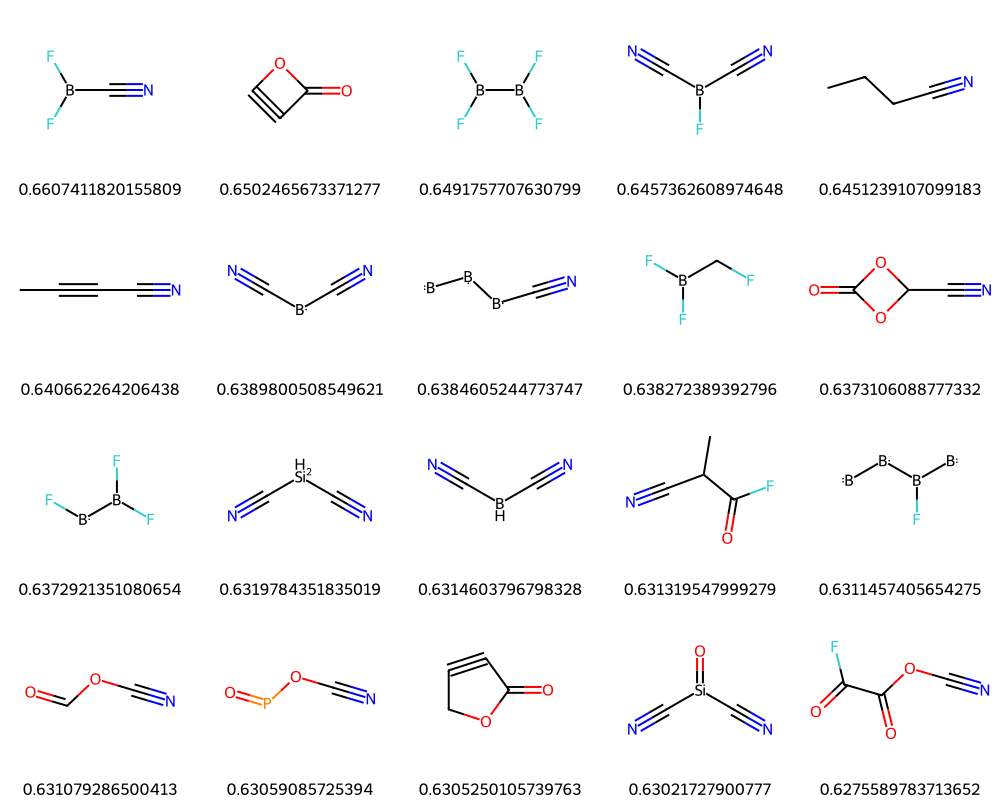

In [46]:
PandasTools.FrameToGridImage(high_score_df_1_.iloc[:20,:], legendsCol="overall_score_1", molsPerRow=5)

In [47]:
high_score_df_1_.to_csv('pub_high_overall_score_wt1.csv', index=False)

2. Very low weights for $\sigma$ & CE; very high weight for IE

In [48]:
cond_score_2 = []
os_score_2 = []
ce_score_2 = []
cond_wt = 0.05
os_wt = 0.9
ce_wt = 0.05
for i in range(len(df_pub)):
    if df_pub['conductivity'][i] >= 1.0 and df_pub['oxstab'][i] >= 4.5 and df_pub['coulombic_efficiency'][i] >= 0.985:
        cond_score_2.append(cond_wt * target_df['cond_std'][i])
        os_score_2.append(os_wt * target_df['oxstab_std'][i])
        ce_score_2.append(ce_wt * target_df['CE_std'][i])
    else:
        cond_score_2.append(0.0)
        os_score_2.append(0.0)
        ce_score_2.append(0.0)

In [49]:
overall_score_2 = [(cond_score_2[i]+os_score_2[i]+ce_score_2[i]) for i in range(len(df_pub))]

In [50]:
target_df['overall_score_2'] = overall_score_2
high_score_df_2 = target_df.loc[target_df['overall_score_2'] > 0.0]
high_score_df_2_ = high_score_df_2.sort_values(by=['overall_score_2'], ascending=False)
high_score_df_2_.reset_index(drop=True, inplace=True)
high_score_df_2_

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency,cond_std,oxstab_std,CE_std,overall_score_1,overall_score_2
0,FB(F)B(F)F,4.099620,9.998654,0.999335,0.061381,0.905890,0.999929,0.649176,0.868366
1,N#CB(F)F,8.262000,9.726532,0.997015,0.123701,0.881168,0.997377,0.660741,0.849105
2,FCB(F)F,5.490258,9.453730,0.995374,0.082202,0.856384,0.995573,0.638272,0.824634
3,F[B]B(F)F,5.320037,9.425592,0.997315,0.079653,0.853827,0.997708,0.637292,0.822313
4,FB(F)B(F)B(F)F,2.789212,9.445062,0.993434,0.041761,0.855596,0.993439,0.623963,0.821797
...,...,...,...,...,...,...,...,...,...
55136,CCN(CC)P1(=S)SCCS1,1.008488,4.503243,0.986103,0.015099,0.406634,0.985378,0.464347,0.415994
55137,CC1(C)C[Si](C)(C)SSC1(C)C,1.099083,4.501482,0.986941,0.016456,0.406474,0.986300,0.465046,0.415964
55138,CCC(CC)C1SCC(C)(C)S1,1.106205,4.500920,0.987272,0.016562,0.406423,0.986664,0.465184,0.415942
55139,CC(C)(C)N(CCC(C)(C)C(C)(C)C)S(C)(=O)=O,1.002207,4.501455,0.985437,0.015005,0.406471,0.984646,0.464021,0.415807


In [51]:
PandasTools.AddMoleculeColumnToFrame(high_score_df_2_, smilesCol='solv_comb_sm')
high_score_df_2_.head()

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency,cond_std,oxstab_std,CE_std,overall_score_1,overall_score_2,ROMol
0,FB(F)B(F)F,4.099620,9.998654,0.999335,0.061381,0.905890,0.999929,0.649176,0.868366,<rdkit.Chem.rdchem.Mol object at 0x2de25add0>
1,N#CB(F)F,8.262000,9.726532,0.997015,0.123701,0.881168,0.997377,0.660741,0.849105,<rdkit.Chem.rdchem.Mol object at 0x2de25ad60>
2,FCB(F)F,5.490258,9.453730,0.995374,0.082202,0.856384,0.995573,0.638272,0.824634,<rdkit.Chem.rdchem.Mol object at 0x2de25a3c0>
3,F[B]B(F)F,5.320037,9.425592,0.997315,0.079653,0.853827,0.997708,0.637292,0.822313,<rdkit.Chem.rdchem.Mol object at 0x2de25a270>
4,FB(F)B(F)B(F)F,2.789212,9.445062,0.993434,0.041761,0.855596,0.993439,0.623963,0.821797,<rdkit.Chem.rdchem.Mol object at 0x2d96fae40>


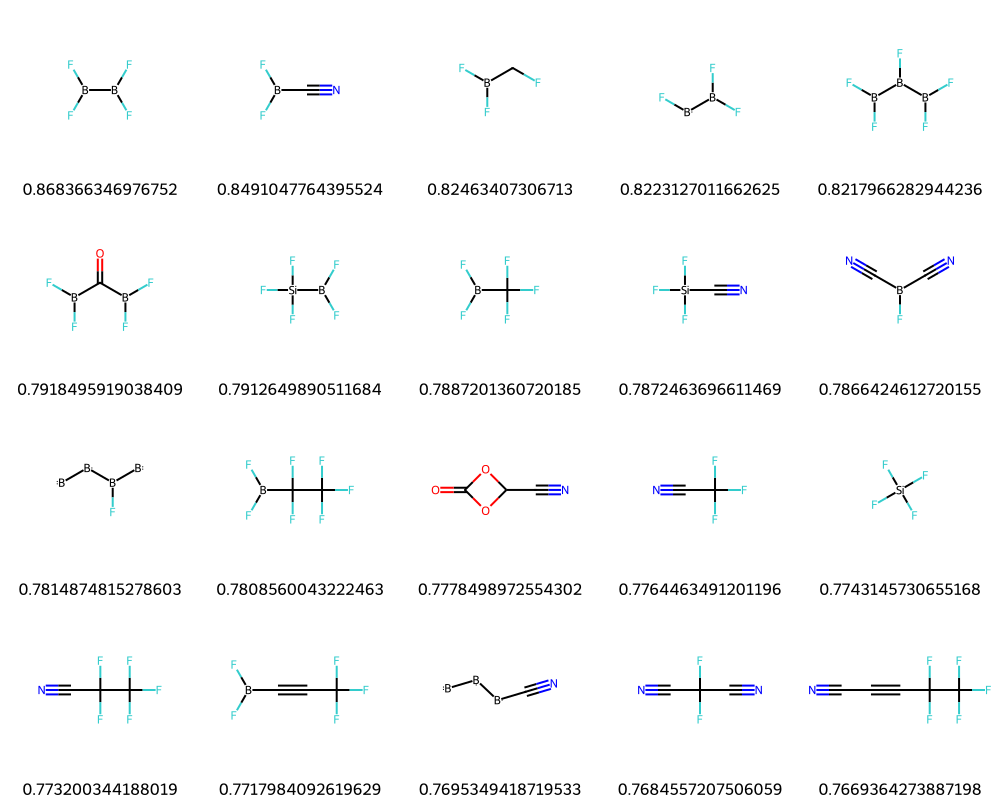

In [52]:
PandasTools.FrameToGridImage(high_score_df_2_.iloc[:20,:], legendsCol="overall_score_2", molsPerRow=5)

In [53]:
high_score_df_2_.drop(labels=['ROMol','overall_score_1'], axis=1, inplace=True)
high_score_df_2_.reset_index(drop=True, inplace=True)
high_score_df_2_.to_csv('pub_high_overall_score_wt2.csv')

3. Very low weights for $\sigma$ & IE; very high weight for CE

In [54]:
cond_score_3 = []
os_score_3 = []
ce_score_3 = []
cond_wt = 0.05
os_wt = 0.05
ce_wt = 0.9
for i in range(len(df_pub)):
    if df_pub['conductivity'][i] >= 1.0 and df_pub['oxstab'][i] >= 4.5 and df_pub['coulombic_efficiency'][i] >= 0.985:
        cond_score_3.append(cond_wt * target_df['cond_std'][i])
        os_score_3.append(os_wt * target_df['oxstab_std'][i])
        ce_score_3.append(ce_wt * target_df['CE_std'][i])
    else:
        cond_score_3.append(0.0)
        os_score_3.append(0.0)
        ce_score_3.append(0.0)

In [55]:
overall_score_3 = [(cond_score_3[i]+os_score_3[i]+ce_score_3[i]) for i in range(len(df_pub))]

In [56]:
target_df['overall_score_3'] = overall_score_3
high_score_df_3 = target_df.loc[target_df['overall_score_3'] > 0.0]
high_score_df_3_ = high_score_df_3.sort_values(by=['overall_score_3'], ascending=False)
high_score_df_3_.reset_index(drop=True, inplace=True)
high_score_df_3_

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency,cond_std,oxstab_std,CE_std,overall_score_1,overall_score_2,overall_score_3
0,FB(F)B(F)F,4.099620,9.998654,0.999335,0.061381,0.905890,0.999929,0.649176,0.868366,0.948299
1,N#CB(F)F,8.262000,9.726532,0.997015,0.123701,0.881168,0.997377,0.660741,0.849105,0.947883
2,[B][B][B]C#N,9.524909,8.739846,0.999938,0.142610,0.791528,1.000591,0.638461,0.769535,0.947239
3,N#C[B]C#N,15.850444,7.718985,0.999584,0.237318,0.698783,1.000203,0.638980,0.690780,0.946988
4,N#C[Si](=O)C#N,9.424366,8.483562,0.999764,0.141104,0.768244,1.000401,0.630217,0.748495,0.945828
...,...,...,...,...,...,...,...,...,...,...
55136,CC(=O)N(C)OCO[Si](C)(C)C(C)(C)C,1.147722,4.513872,0.985159,0.017184,0.407599,0.984340,0.465011,0.416916,0.907145
55137,COCC(COC)(COCC(C)(C)C)C(C)(C)C,1.114389,4.511561,0.985164,0.016685,0.407390,0.984346,0.464779,0.416702,0.907115
55138,COCC(COC)(COC(C)(C)C(C)C)C(C)C,1.074703,4.538387,0.985068,0.016091,0.409827,0.984240,0.465352,0.418861,0.907112
55139,CCCC1(C)CCCCN1C(F)(F)F,1.128706,4.512120,0.985075,0.016899,0.407440,0.984248,0.464834,0.416754,0.907041


In [57]:
PandasTools.AddMoleculeColumnToFrame(high_score_df_3_, smilesCol='solv_comb_sm')
high_score_df_3_.head()

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency,cond_std,oxstab_std,CE_std,overall_score_1,overall_score_2,overall_score_3,ROMol
0,FB(F)B(F)F,4.099620,9.998654,0.999335,0.061381,0.905890,0.999929,0.649176,0.868366,0.948299,<rdkit.Chem.rdchem.Mol object at 0x2f52f94a0>
1,N#CB(F)F,8.262000,9.726532,0.997015,0.123701,0.881168,0.997377,0.660741,0.849105,0.947883,<rdkit.Chem.rdchem.Mol object at 0x2f52f9eb0>
2,[B][B][B]C#N,9.524909,8.739846,0.999938,0.142610,0.791528,1.000591,0.638461,0.769535,0.947239,<rdkit.Chem.rdchem.Mol object at 0x2f52f4e40>
3,N#C[B]C#N,15.850444,7.718985,0.999584,0.237318,0.698783,1.000203,0.638980,0.690780,0.946988,<rdkit.Chem.rdchem.Mol object at 0x2f52f4f90>
4,N#C[Si](=O)C#N,9.424366,8.483562,0.999764,0.141104,0.768244,1.000401,0.630217,0.748495,0.945828,<rdkit.Chem.rdchem.Mol object at 0x2f52f4f20>


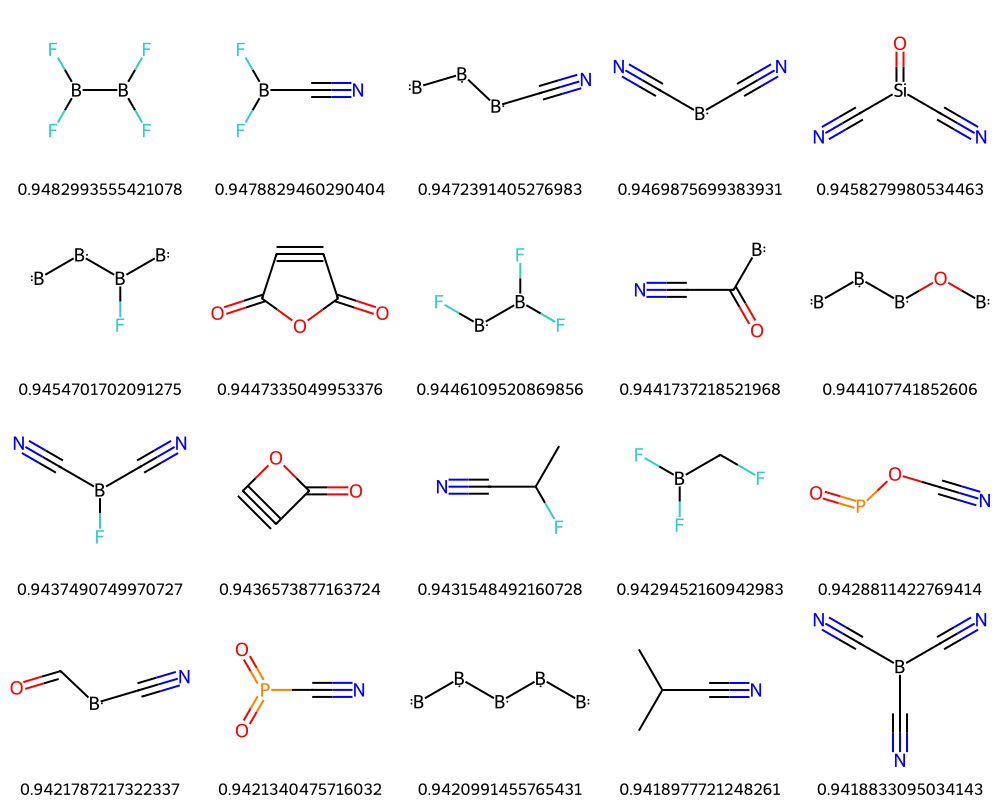

In [58]:
PandasTools.FrameToGridImage(high_score_df_3_.iloc[:20,:], legendsCol="overall_score_3", molsPerRow=5)

In [59]:
high_score_df_3_.drop(labels=['ROMol','overall_score_1','overall_score_2'], axis=1, inplace=True)
high_score_df_3_.reset_index(drop=True, inplace=True)
high_score_df_3_.to_csv('pub_high_overall_score_wt3.csv')

4. Very low weights for IE & CE; very high weight for $\sigma$

In [60]:
cond_score_4 = []
os_score_4 = []
ce_score_4 = []
cond_wt = 0.9
os_wt = 0.05
ce_wt = 0.05
for i in range(len(df_pub)):
    if df_pub['conductivity'][i] >= 1.0 and df_pub['oxstab'][i] >= 4.5 and df_pub['coulombic_efficiency'][i] >= 0.985:
        cond_score_4.append(cond_wt * target_df['cond_std'][i])
        os_score_4.append(os_wt * target_df['oxstab_std'][i])
        ce_score_4.append(ce_wt * target_df['CE_std'][i])
    else:
        cond_score_4.append(0.0)
        os_score_4.append(0.0)
        ce_score_4.append(0.0)

In [61]:
overall_score_4 = [(cond_score_4[i]+os_score_4[i]+ce_score_4[i]) for i in range(len(df_pub))]

In [62]:
target_df['overall_score_4'] = overall_score_4
high_score_df_4 = target_df.loc[target_df['overall_score_4'] > 0.0]
high_score_df_4_ = high_score_df_4.sort_values(by=['overall_score_4'], ascending=False)
high_score_df_4_.reset_index(drop=True, inplace=True)
high_score_df_4_

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency,cond_std,oxstab_std,CE_std,overall_score_1,overall_score_2,overall_score_3,overall_score_4
0,CPCC#N,20.658909,5.439222,0.986629,0.309311,0.491667,0.985957,0.589689,0.507264,0.927410,0.352261
1,COCC#N,19.269595,6.544041,0.986828,0.288510,0.592040,0.986176,0.616019,0.596570,0.931586,0.338570
2,CCCC#N,18.455603,7.576662,0.992803,0.276323,0.685853,0.992745,0.645124,0.680721,0.941580,0.332620
3,C[CH]CC#N,18.748077,6.571165,0.994203,0.280702,0.594504,0.994285,0.616932,0.598803,0.938617,0.332071
4,O=C1C#CO1,16.956022,7.977809,0.994195,0.253871,0.722297,0.994277,0.650247,0.712474,0.943657,0.314312
...,...,...,...,...,...,...,...,...,...,...,...
55136,CCCC(C)O[Si](OCC)OCC,1.001745,4.562026,0.986109,0.014998,0.411974,0.985385,0.466078,0.420796,0.908195,0.083367
55137,CC(C)(C)CC(C)(C)CN(C(C)(C)C)S(C)(=O)=O,1.015384,4.510472,0.986705,0.015203,0.407291,0.986040,0.464816,0.416624,0.908561,0.083349
55138,CCN(CC)P1(=S)SCCS1,1.008488,4.503243,0.986103,0.015099,0.406634,0.985378,0.464347,0.415994,0.907927,0.083190
55139,COC(C)CCO[Si](C)(C)C(C)(C)C,1.002684,4.505516,0.985114,0.015012,0.406840,0.984291,0.464027,0.416121,0.906955,0.083068


In [63]:
PandasTools.AddMoleculeColumnToFrame(high_score_df_4_, smilesCol='solv_comb_sm')
high_score_df_4_.head()

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency,cond_std,oxstab_std,CE_std,overall_score_1,overall_score_2,overall_score_3,overall_score_4,ROMol
0,CPCC#N,20.658909,5.439222,0.986629,0.309311,0.491667,0.985957,0.589689,0.507264,0.927410,0.352261,<rdkit.Chem.rdchem.Mol object at 0x313f8f660>
1,COCC#N,19.269595,6.544041,0.986828,0.288510,0.592040,0.986176,0.616019,0.596570,0.931586,0.338570,<rdkit.Chem.rdchem.Mol object at 0x30d6a8970>
2,CCCC#N,18.455603,7.576662,0.992803,0.276323,0.685853,0.992745,0.645124,0.680721,0.941580,0.332620,<rdkit.Chem.rdchem.Mol object at 0x30d6a82e0>
3,C[CH]CC#N,18.748077,6.571165,0.994203,0.280702,0.594504,0.994285,0.616932,0.598803,0.938617,0.332071,<rdkit.Chem.rdchem.Mol object at 0x30d6a8f90>
4,O=C1C#CO1,16.956022,7.977809,0.994195,0.253871,0.722297,0.994277,0.650247,0.712474,0.943657,0.314312,<rdkit.Chem.rdchem.Mol object at 0x30d6a89e0>


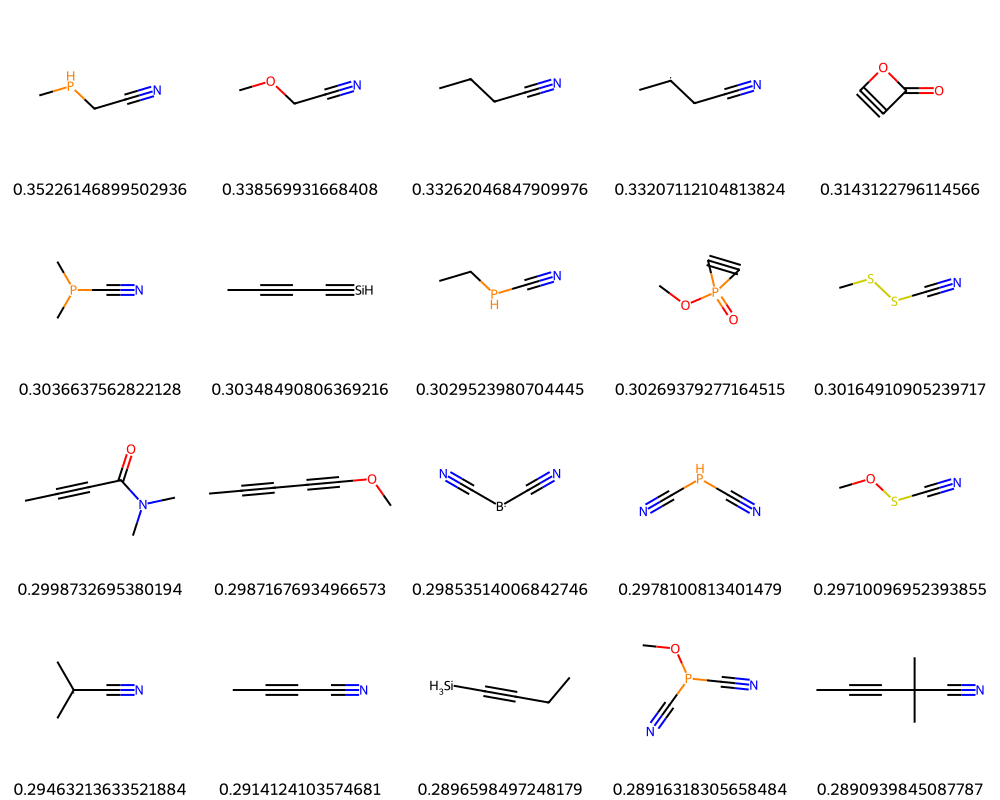

In [64]:
PandasTools.FrameToGridImage(high_score_df_4_.iloc[:20,:], legendsCol="overall_score_4", molsPerRow=5)

In [55]:
high_score_df_4_.drop(labels=['ROMol','overall_score_1','overall_score_2','overall_score_3'], axis=1, inplace=True)
high_score_df_4_.reset_index(drop=True, inplace=True)
high_score_df_4_.to_csv('pub_high_overall_score_wt4.csv')

**Checking for 1 M electrolyte predictions - not used in final manuscript**

In [3]:
df_emol = pd.read_csv('preds_cond_emolecules_screened_021124.csv')
df_emol_ce = pd.read_csv('preds_ce_emol_screened_021124.csv')
df_emol_os = pd.read_csv('preds_oxstab_emolecules_screened_021124.csv')

In [4]:
## reading original datasets
df_cond = pd.read_csv('all_multi_comp_cond_comm.csv')
df_cond['conductivity'] = np.power(10, df_cond['conductivity_log'])
cond = df_cond['conductivity']
df_os = pd.read_csv('all_oxstab.csv')
oxstab = df_os['IE']
df_ce = pd.read_csv('all_multi_comp_ce.csv')
ce = df_ce['coulombic_efficiency']
df_ce

,solvent_1_smiles,solvent_2_smiles,solvent_3_smiles,salt_1_smiles,salt_2_smiles,additive_smiles,protocol,current_density,coulombic_efficiency
0,CC1COC(=O)O1,NaN,NaN,[Li+].[O-][Cl+3]([O-])([O-])[O-],NaN,NaN,0,2.0,0.80000
1,CC1COC(=O)O1,NaN,NaN,[Li+].[O-][Cl+3]([O-])([O-])[O-],NaN,O=S=O,1,5.0,0.83600
2,C1CCOC1,NaN,NaN,F[As-](F)(F)(F)(F)F.[Li+],NaN,NaN,1,5.0,0.89400
3,CC1CCCO1,NaN,NaN,F[As-](F)(F)(F)(F)F.[Li+],NaN,NaN,1,0.9,0.97400
4,CC1CCCO1,NaN,NaN,F[As-](F)(F)(F)(F)F.[Li+],NaN,NaN,1,0.9,0.97400
...,...,...,...,...,...,...,...,...,...
137,CO[Si](C)(C)OC,NaN,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,2,0.5,0.99759
138,O=S1(=O)CCCC1,NaN,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,2,0.5,0.98200
139,O=S1(=O)CCCC1,FC(F)C(F)(F)COC(F)(F)C(F)F,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,2,0.5,0.98800
140,COC1OCC(C(F)(F)F)O1,NaN,NaN,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],NaN,NaN,2,1.0,0.98700


In [5]:
df_emol['conductivity'] = np.power(10, df_emol['conductivity_log'])
df_emol['coulombic_efficiency'] = 1 - np.power(10, df_emol_ce['log(1-CE)'])
df_emol['oxstab'] = df_emol_os['IE']
df_emol

,solv_comb_sm,salt_sm,conductivity_log,conductivity_log_ensemble_uncal_var,conductivity,coulombic_efficiency,oxstab
0,CC(=O)C#N,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.496380,0.061641,3.136031,0.992383,7.488391
1,CC(=O)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.323279,0.041828,2.105130,0.997375,6.355432
2,O=C1CCO1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.138788,0.004402,13.765388,0.964965,6.973953
3,CCCC=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.869589,0.005092,7.406098,0.988669,5.978584
4,O=CC1CO1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.713039,0.014474,5.164625,0.991071,6.796157
...,...,...,...,...,...,...,...
76599,C(CP(C1CCCCC1)C1CCCCC1)CP(C1CCCCC1)C1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.068743,0.022824,0.853606,0.926191,3.913700
76600,ClCC(CCl)OP(=O)(OC(CCl)CCl)OC(CCl)CCl,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.917413,0.089262,0.120945,0.962381,5.937648
76601,C(CCP(C1CCCCC1)C1CCCCC1)CP(C1CCCCC1)C1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.194676,0.028547,0.638740,0.923302,3.916934
76602,S=P(N1CC1)(N1CC1)N1CCN(CC1)P(=S)(N1CC1)N1CC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.232416,0.037728,1.707718,0.984529,4.147219


In [6]:
emol_cond = df_emol['conductivity']
emol_os = df_emol['oxstab']
emol_ce = df_emol['coulombic_efficiency']

In [7]:
## Extreme values of all predicted properties for emolecules dataset
print(max(emol_cond), min(emol_cond))
print(max(emol_os), min(emol_os))
print(max(emol_ce), min(emol_ce))

20.587940173630717 0.0008362898341019088
8.790046848261573 2.6710439932569585
0.9999999967894386 0.3782630299241635


In [8]:
## Define a scaler for conductivity
cond_div = np.linspace(max(cond), min(cond),1000000) ## dividing the range into 1 million points
cond_div = cond_div.reshape(-1, 1)
scaler_cond = preprocessing.MinMaxScaler() ## Using MinMax Scaler
scaler_cond.fit(cond_div)
cond_sc = scaler_cond.transform(cond_div)
cond_sc

array([[1.000000e+00],
       [9.999990e-01],
       [9.999980e-01],
       ...,
       [2.000002e-06],
       [1.000001e-06],
       [0.000000e+00]])

In [9]:
## Standardize the original conductivity values
emol_cond = np.array(emol_cond).reshape(-1,1)
emol_cond_sc = scaler_cond.transform(emol_cond)
print(emol_cond_sc)
print(max(emol_cond_sc), min(emol_cond_sc))

[[0.0469536 ]
 [0.03151864]
 [0.20609953]
 ...
 [0.00956341]
 [0.02556846]
 [0.0101952 ]]
[0.30824884] [1.25185033e-05]


In [10]:
## Define a scaler for oxidative stability
os_div = np.linspace(max(oxstab), min(oxstab),1000000).reshape(-1, 1)
scaler_os = preprocessing.MinMaxScaler()
scaler_os.fit(os_div)
scaler_os.transform(os_div)

array([[1.000000e+00],
       [9.999990e-01],
       [9.999980e-01],
       ...,
       [2.000002e-06],
       [1.000001e-06],
       [0.000000e+00]])

In [13]:
## Standardize the original oxidative stability values
emol_os = np.array(emol_os).reshape(-1,1)
emol_os_sc = scaler_os.transform(emol_os)
print(emol_os_sc)
print(max(emol_os_sc), min(emol_os_sc))

[[0.67783342]
 [0.57490446]
 [0.63109692]
 ...
 [0.35336789]
 [0.37428914]
 [0.47554579]]
[0.79608833] [0.24017923]


In [11]:
## Define a scaler for coulombic efficiency
ce_div = np.linspace(max(ce), min(ce),1000000).reshape(-1, 1)
scaler_ce = preprocessing.MinMaxScaler()
scaler_ce.fit(ce_div)
scaler_ce.transform(ce_div)

array([[1.000000e+00],
       [9.999990e-01],
       [9.999980e-01],
       ...,
       [2.000002e-06],
       [1.000001e-06],
       [0.000000e+00]])

In [12]:
## Standardize the original coulombic efficiency values
emol_ce = np.array(emol_ce).reshape(-1,1)
emol_ce_sc = scaler_ce.transform(emol_ce)
print(emol_ce_sc)
print(max(emol_ce_sc), min(emol_ce_sc))

[[0.99228412]
 [0.99777288]
 [0.96213462]
 ...
 [0.91632078]
 [0.98364717]
 [0.97441849]]
[1.00065977] [0.31698156]


In [14]:
## Combine the standardized values into a dataframe
target_df = pd.DataFrame()
target_df['solv_comb_sm'] = df_emol['solv_comb_sm']
target_df['conductivity'] = df_emol['conductivity']
target_df['oxstab'] = df_emol['oxstab']
target_df['coulombic_efficiency'] = df_emol['coulombic_efficiency']
# target_df['similarity'] = emol_max_sim
target_df

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency
0,CC(=O)C#N,3.136031,7.488391,0.992383
1,CC(=O)C=O,2.105130,6.355432,0.997375
2,O=C1CCO1,13.765388,6.973953,0.964965
3,CCCC=O,7.406098,5.978584,0.988669
4,O=CC1CO1,5.164625,6.796157,0.991071
...,...,...,...,...
76599,C(CP(C1CCCCC1)C1CCCCC1)CP(C1CCCCC1)C1CCCCC1,0.853606,3.913700,0.926191
76600,ClCC(CCl)OP(=O)(OC(CCl)CCl)OC(CCl)CCl,0.120945,5.937648,0.962381
76601,C(CCP(C1CCCCC1)C1CCCCC1)CP(C1CCCCC1)C1CCCCC1,0.638740,3.916934,0.923302
76602,S=P(N1CC1)(N1CC1)N1CCN(CC1)P(=S)(N1CC1)N1CC1,1.707718,4.147219,0.984529


In [15]:
target_df['cond_std'] = emol_cond_sc
target_df['oxstab_std'] = emol_os_sc
target_df['CE_std'] = emol_ce_sc

In [16]:
target_df.loc[target_df['solv_comb_sm'] == 'CCN1CCOCC1'] ## EM

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency,cond_std,oxstab_std,CE_std
853,CCN1CCOCC1,7.207945,3.867303,0.972619,0.10792,0.348859,0.970551


In [17]:
target_df.loc[target_df['solv_comb_sm'] == 'COC(=O)C#N'] ## MCF

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency,cond_std,oxstab_std,CE_std
74,COC(=O)C#N,13.934594,7.942341,0.989588,0.208633,0.719075,0.989211


In [18]:
target_df.loc[target_df['solv_comb_sm'] == 'CCS(F)(=O)=O'] ## ESF

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency,cond_std,oxstab_std,CE_std
2651,CCS(F)(=O)=O,5.376645,7.197885,0.993486,0.080501,0.651441,0.993497


In [19]:
target_df.loc[target_df['solv_comb_sm'] == 'CCOCCS(F)(=O)=O'] ## EESF

,solv_comb_sm,conductivity,oxstab,coulombic_efficiency,cond_std,oxstab_std,CE_std
7456,CCOCCS(F)(=O)=O,3.689972,6.861181,0.988739,0.055247,0.620852,0.988276
